#Import Libraries

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from mne.io.constants import FIFF
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from mne import make_fixed_length_epochs
from copy import deepcopy
from xgboost import XGBClassifier
from mne.viz import plot_topomap
from mne import pick_info
import scipy.io as sio
import pandas as pd
import numpy as np
import seaborn as sns
import os
import mne
import torch
import torch.nn as nn
import torch.nn.functional as F

#Load Necessary Files


##Load MAT Files

In [ ]:
#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define the shared dataset path folder
shared_dataset_path = ('/content/drive/MyDrive/IntroToDS-Project/Dataset') #this path should be the same for all of us

In [ ]:
#define path for the adhd and control datasets
adhd_path = os.path.join(shared_dataset_path, 'ADHD_part1', 'ADHD_part1') #path to the adhd folder
control_path = os.path.join(shared_dataset_path, 'Control_part1', 'Control_part1') #path to the control folder

In [ ]:
#function to load MAT files from the folder path
def load_mat_files(folder_path):
  mat_files = []
  for filename in os.listdir(folder_path):
    if filename.endswith('.mat'):
      mat_file = sio.loadmat(os.path.join(folder_path, filename))
      mat_files.append(mat_file)
      print(f"Loaded {filename}") #to confirm the loading of the files
  return mat_files

#load mat files from both folders
adhd_data = load_mat_files(adhd_path)
control_data = load_mat_files(control_path)

Loaded v10p.mat
Loaded v28p.mat
Loaded v12p.mat
Loaded v27p.mat
Loaded v15p.mat
Loaded v19p.mat
Loaded v20p.mat
Loaded v25p.mat
Loaded v24p.mat
Loaded v22p.mat
Loaded v1p.mat
Loaded v14p.mat
Loaded v173.mat
Loaded v18p.mat
Loaded v21p.mat
Loaded v38p.mat
Loaded v40p.mat
Loaded v39p.mat
Loaded v31p.mat
Loaded v8p.mat
Loaded v35p.mat
Loaded v32p.mat
Loaded v36p.mat
Loaded v29p.mat
Loaded v34p.mat
Loaded v3p.mat
Loaded v37p.mat
Loaded v6p.mat
Loaded v30p.mat
Loaded v33p.mat
Loaded v108.mat
Loaded v109.mat
Loaded v112.mat
Loaded v110.mat
Loaded v111.mat
Loaded v115.mat
Loaded v114.mat
Loaded v107.mat
Loaded v116.mat
Loaded v41p.mat
Loaded v113.mat
Loaded v47p.mat
Loaded v58p.mat
Loaded v43p.mat
Loaded v49p.mat
Loaded v50p.mat
Loaded v57p.mat
Loaded v52p.mat
Loaded v51p.mat
Loaded v42p.mat
Loaded v44p.mat
Loaded v45p.mat
Loaded v53p.mat
Loaded v55p.mat
Loaded v48p.mat
Loaded v46p.mat
Loaded v54p.mat
Loaded v56p.mat
Loaded v60p.mat
Loaded v59p.mat


##Load Channel Labels

In [ ]:
#load the channel labels
channel_df = pd.read_excel(os.path.join(shared_dataset_path, 'Channel_Labels', 'channel_labels.xlsx'))

#list of the channel names
channel_names = channel_df['labels'].tolist()

#Load CED File for Montage

###DO NOT NEED TO RUN THIS BLOCK ANYMORE

In [ ]:
#convert the .ced file to .eloc
ced_path = (os.path.join(shared_dataset_path, 'Standard-10-20-Cap19new', 'Standard-10-20-Cap19new.ced'))

#read ced file
ced_df = pd.read_csv(ced_path, sep='\t', skipinitialspace=True)

#extract the needed columns for mne analysis
ced_df = ced_df[['labels', 'X', 'Y', 'Z']]

#save the .eloc file
eloc_path = os.path.join(shared_dataset_path, 'Standard-10-20-Cap19new', 'Standard-10-20-Cap19new.eloc')
ced_df.to_csv(eloc_path, sep='\t', index=False, header=False)

###Only need to run this one

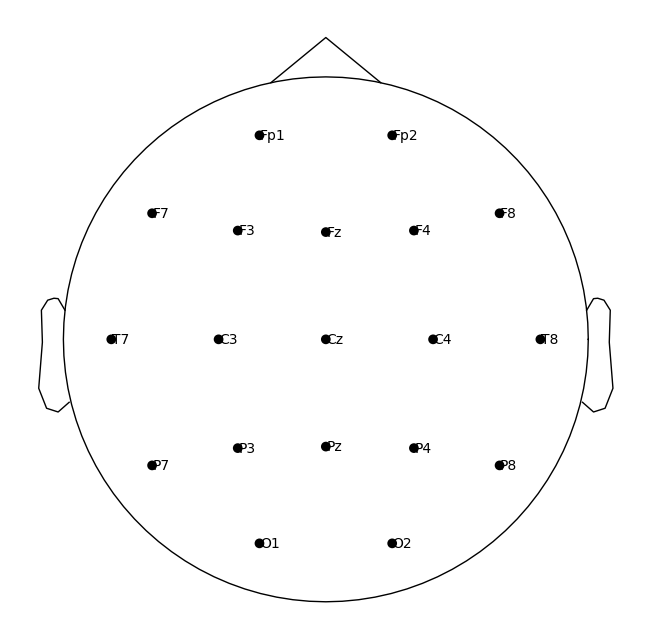

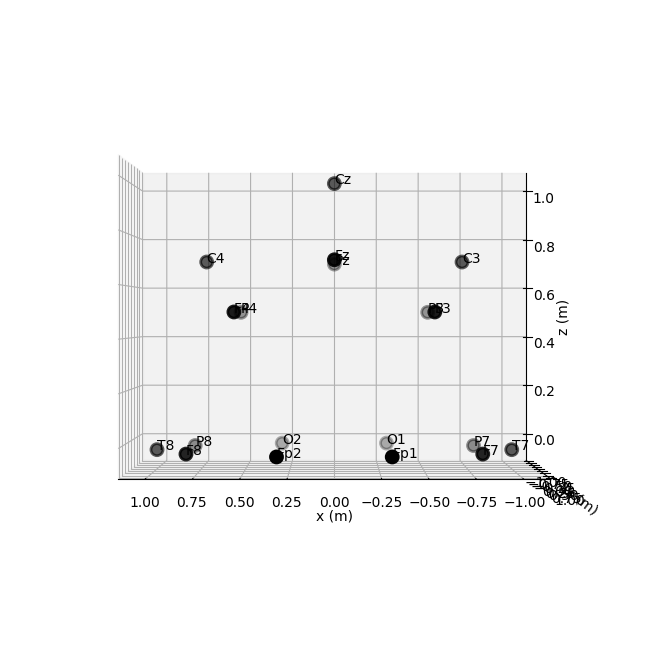

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


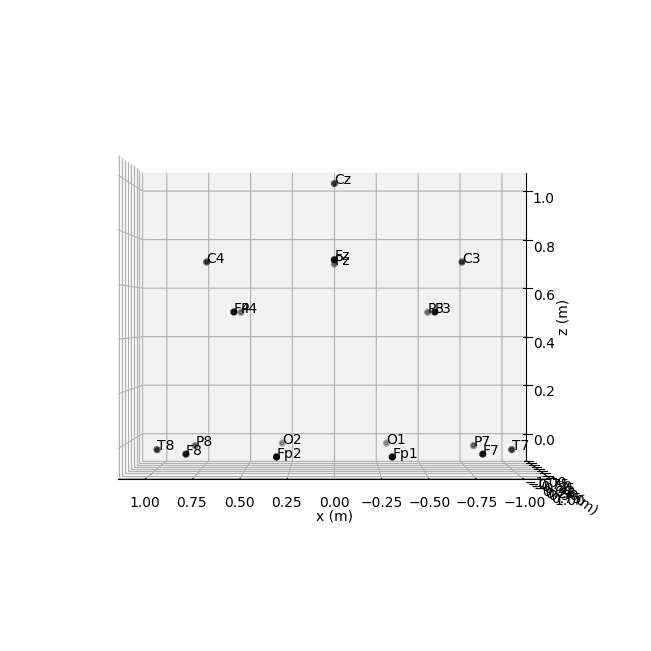

In [ ]:
loc_path = (os.path.join(shared_dataset_path, 'Standard-10-20-Cap19new', 'electrodelocs.xlsx'))

loc_df = pd.read_excel(loc_path)

#build dict of positions
ch_pos = {
    row['Label']: [row['X'], row['Y'], row['Z']]
    for _, row in loc_df.iterrows()
}


#create mne montage
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

#eotate coordinates, to align with the plotting
for ch in montage.dig:
    if ch['kind'] == FIFF.FIFFV_POINT_EEG:
        x, y, z = ch['r']
        ch['r'][0] = -y
        ch['r'][1] = x
        ch['r'][2] = z

#plot montage
montage.plot(kind='topomap', sphere=1.25)
montage.plot(kind='3d')

#Preprocessing

##Find shortest length across all file

Minimum trial length across all files: 7983 timepoints


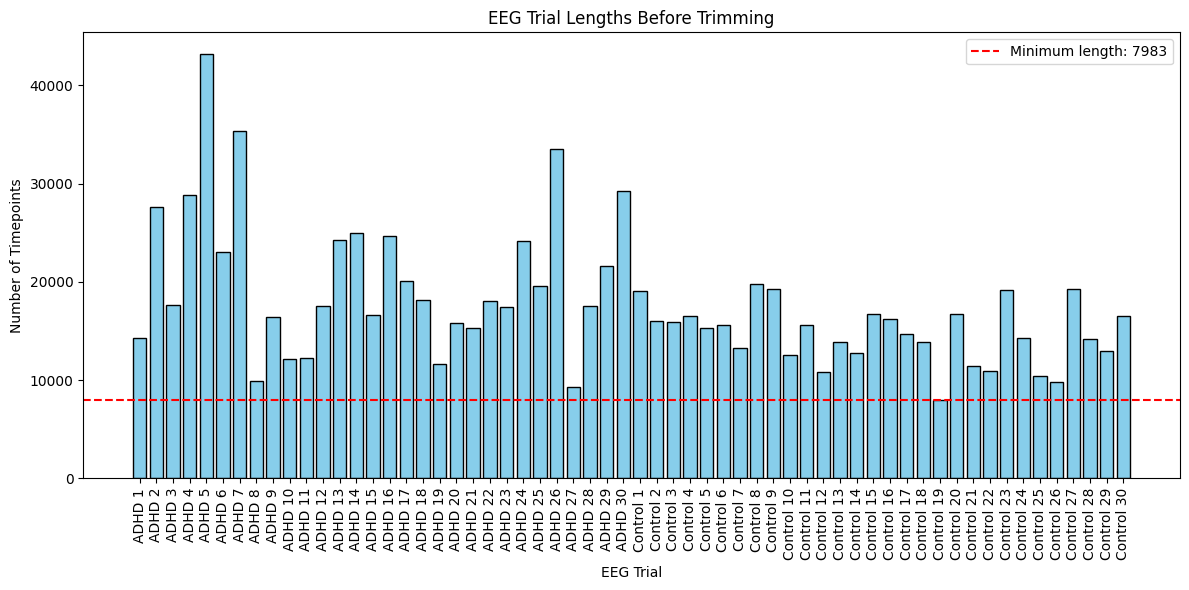

In [ ]:
#find the shortest length from all trials
def find_min_length(adhd_data, control_data):
    lengths = []
    labels = []

    # Function to get length from mat file
    def get_length(mat_file):
        data_key = list(mat_file.keys())[3]  # assuming data is always at index 3
        eeg_array = mat_file[data_key]
        return eeg_array.shape[0]  # time dimension

    for idx, mat_file in enumerate(adhd_data):
        length = get_length(mat_file)
        lengths.append(length)
        labels.append(f"ADHD {idx+1}")

    for idx, mat_file in enumerate(control_data):
        length = get_length(mat_file)
        lengths.append(length)
        labels.append(f"Control {idx+1}")

    #find min length
    min_length = min(lengths)
    print(f"Minimum trial length across all files: {min_length} timepoints")

    #plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, lengths, color='skyblue', edgecolor='black')
    plt.axhline(min_length, color='red', linestyle='--', label=f'Minimum length: {min_length}')
    plt.xticks(rotation=90)
    plt.xlabel('EEG Trial')
    plt.ylabel('Number of Timepoints')
    plt.title('EEG Trial Lengths Before Trimming')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return min_length

min_length = find_min_length(adhd_data, control_data)

##Create MNE Raw Objects

In [ ]:
#build the raw dataset
def build_raw_dataset(adhd_data, control_data, channel_names, sfreq=128, montage=montage, min_length=None):

  #function to convert mat file to mne raw object
  def mat_to_raw(mat_file, data_key, label):

    #get eeg info from mat file
    eeg_array = mat_file[data_key]

    #transpose the eeg array from (n_times, n_channels) to (n_channels, n_times)
    eeg_array = eeg_array[:min_length, :20].T #replace with num of channels and min length

    #create info object
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=len(channel_names)*['eeg'])

    #create raw object
    raw = mne.io.RawArray(eeg_array, info)

    #apply montage
    raw.set_montage(montage)

    return (raw, label)

  raw_dataset = []

  #process adhd group
  for mat_file in adhd_data:
    data_key = list(mat_file.keys())[3]
    raw_dataset.append(mat_to_raw(mat_file, data_key, label=1))

  #process control group
  for mat_file in control_data:
    data_key = list(mat_file.keys())[3]
    raw_dataset.append(mat_to_raw(mat_file, data_key, label=0))

  return raw_dataset

labeled_ds = build_raw_dataset(adhd_data, control_data,  channel_names, min_length=min_length)

Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.359 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=7983
    Range : 0 ... 7982 =      0.000 ...    62.

##Visualization Before Preprocessing

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


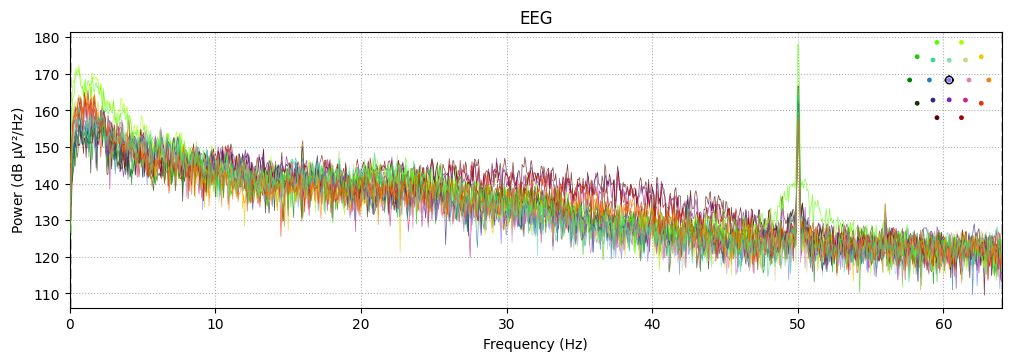

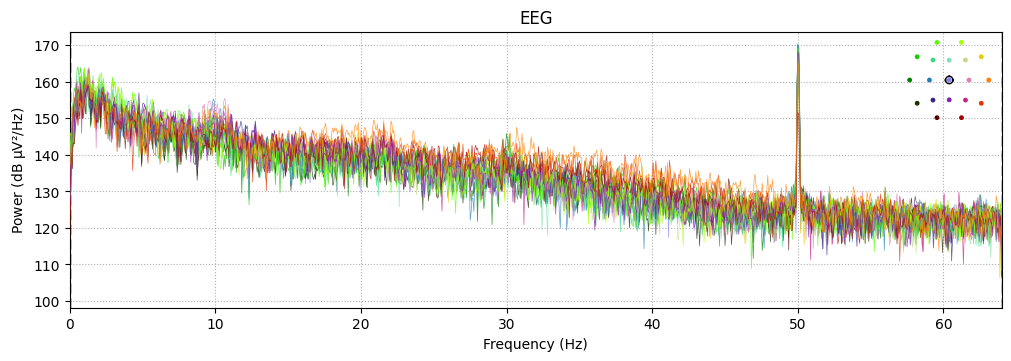

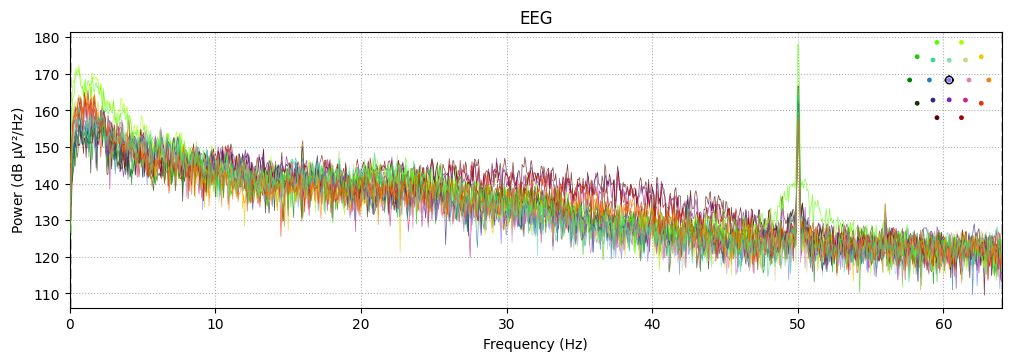

In [ ]:
#visualize one ADHD and one control subject
raw_adhd = labeled_ds[0][0]
raw_control = labeled_ds[-1][0]

#plot power spectral densities
raw_adhd.plot_psd()
raw_control.plot_psd()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


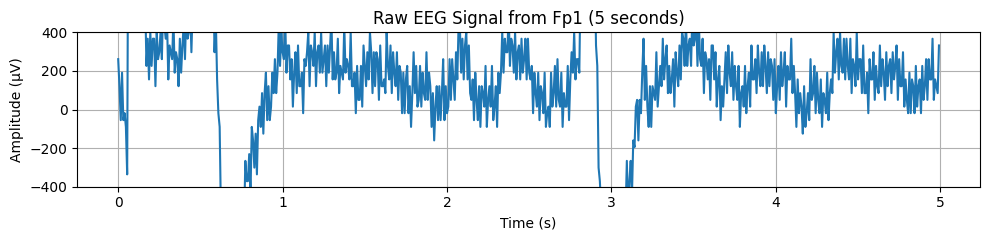

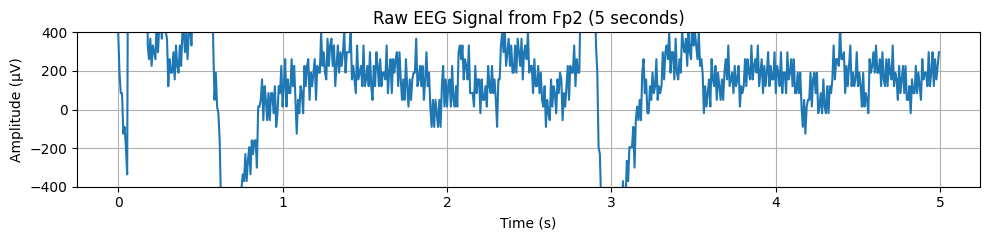

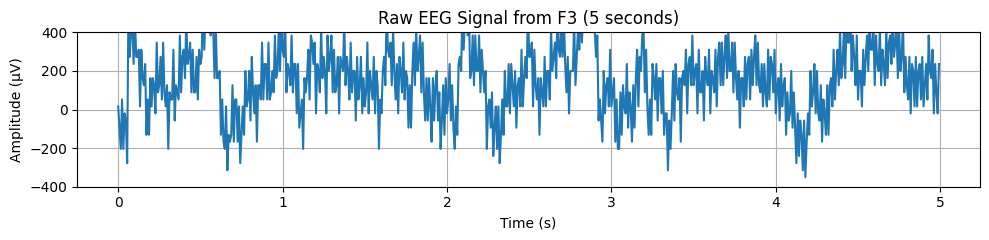

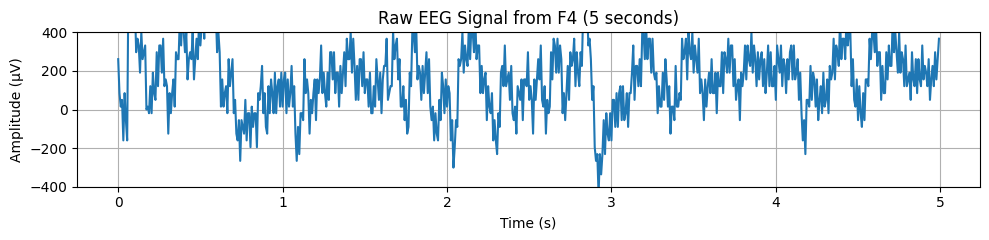

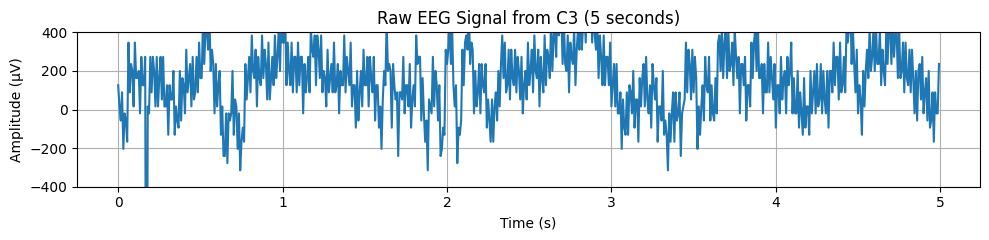

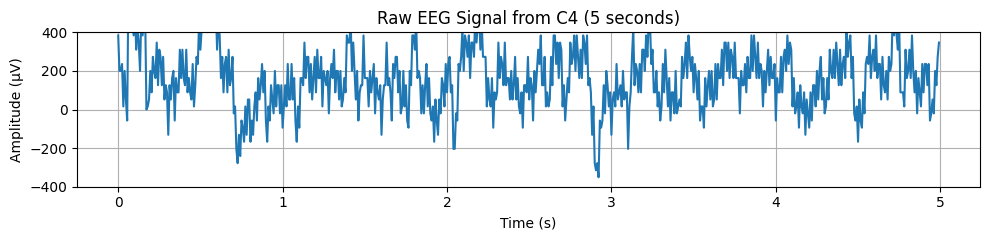

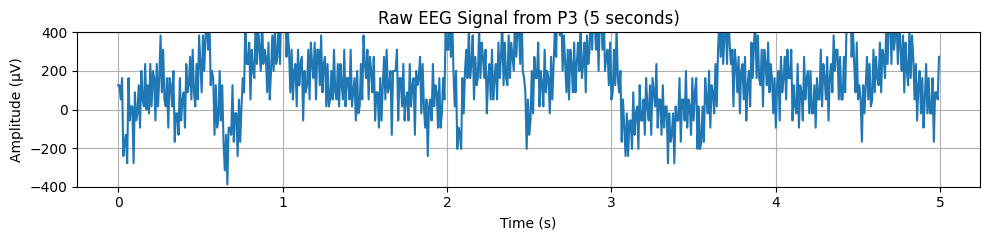

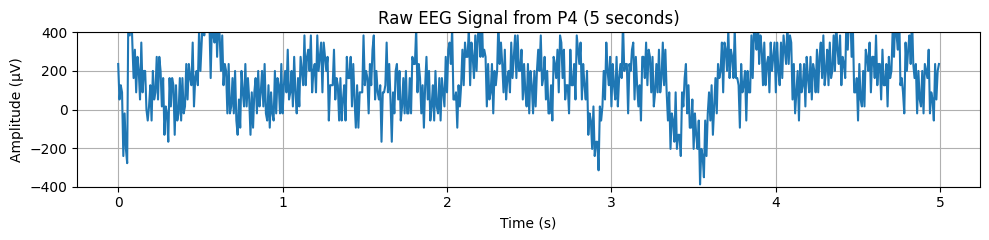

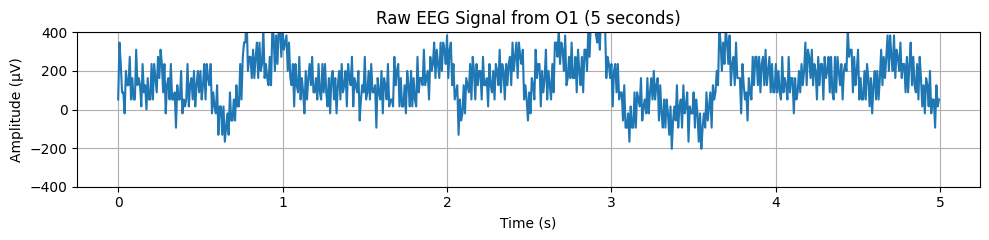

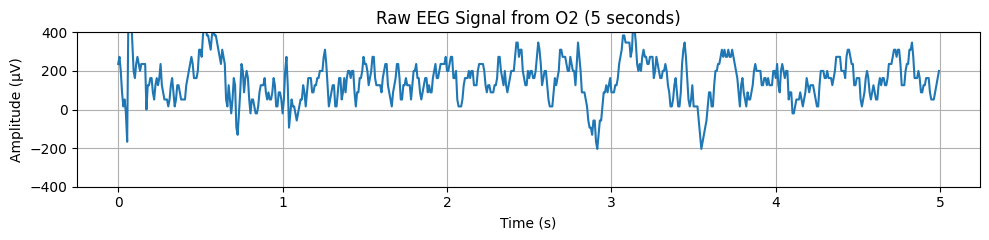

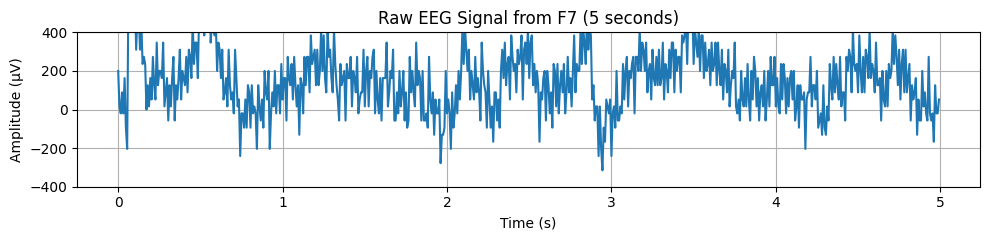

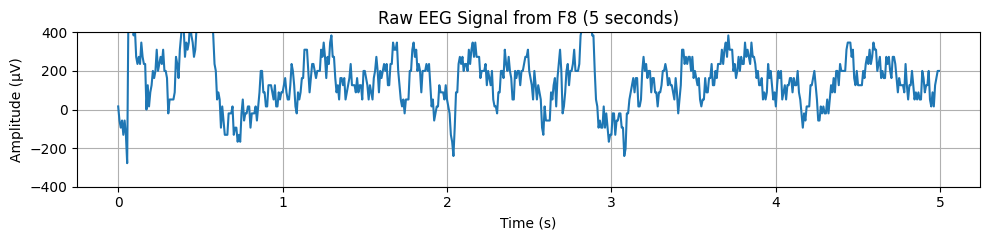

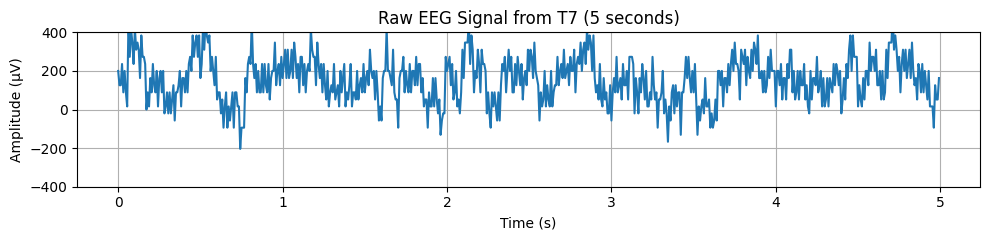

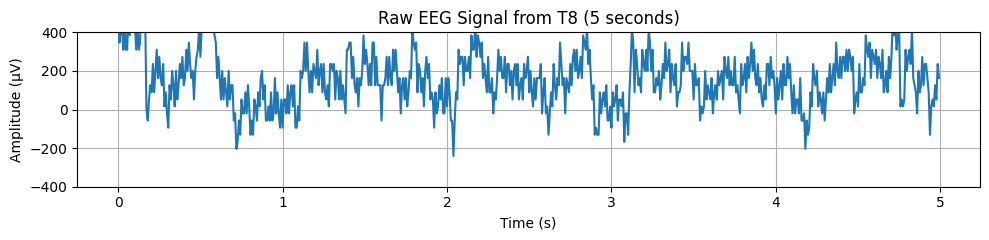

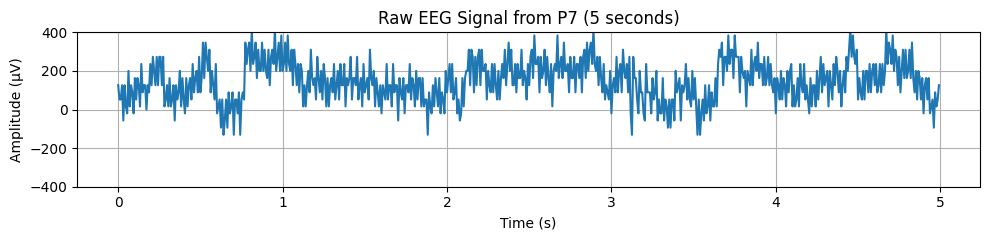

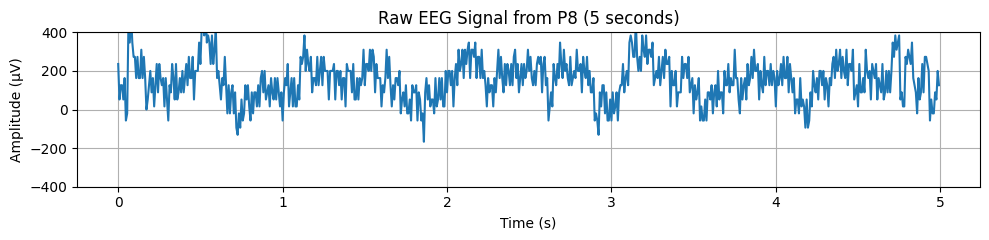

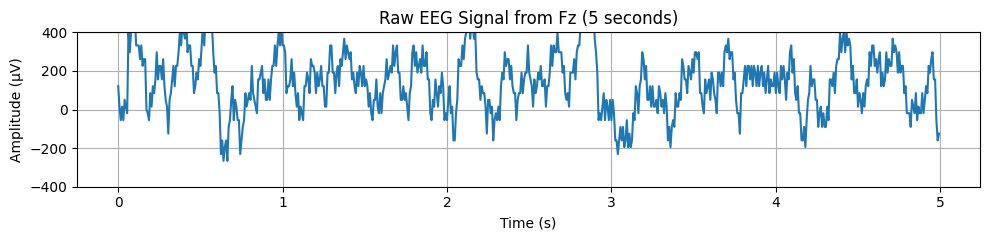

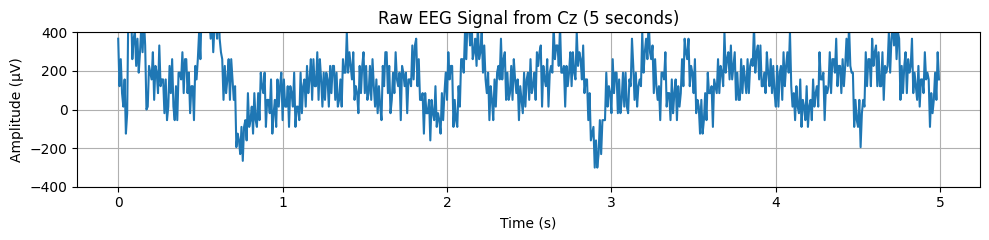

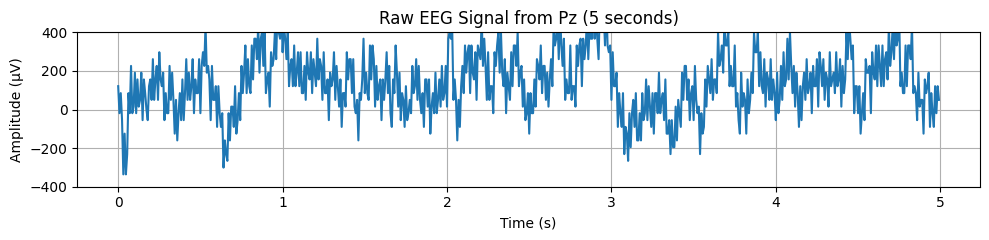

In [ ]:
sample_raw = labeled_ds[0][0]

#define time window
start_sec = 0
duration_sec = 5
start_sample = int(start_sec * sample_raw.info['sfreq'])
end_sample = int((start_sec + duration_sec) * sample_raw.info['sfreq'])

#extract all eeg channels
raw_eeg = sample_raw.copy().pick_types(eeg=True)
data, times = raw_eeg[:, start_sample:end_sample]
channel_names = raw_eeg.info['ch_names']
n_channels = len(channel_names)

#plot each channel
for i in range(n_channels):
    plt.figure(figsize=(10, 2.5))
    plt.plot(times, data[i])
    plt.title(f'Raw EEG Signal from {channel_names[i]} ({duration_sec} seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.ylim(-400, 400)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 640 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


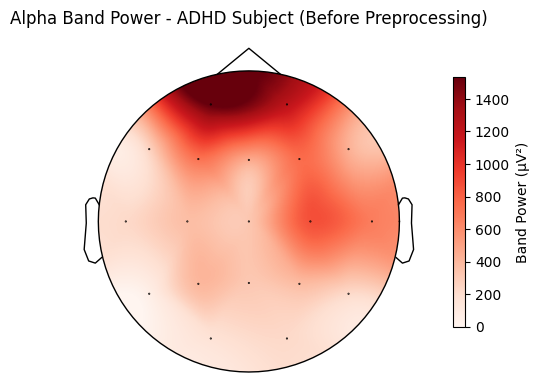

In [ ]:
#get first ADHD sample
raw_before = labeled_ds[0][0].copy()

#treat fp1 and fp2 as eeg channels
raw_before.set_channel_types({'Fp1': 'eeg', 'Fp2': 'eeg'})

#create 5 second epochs
epochs_before = mne.make_fixed_length_epochs(raw_before, duration=5, preload=True)
sample_epoch = epochs_before.get_data()[0]

#compute psd
psds, freqs = mne.time_frequency.psd_array_welch(sample_epoch, sfreq=raw_before.info['sfreq'], fmin=1, fmax=50)

#define the alpha band
alpha_band = (8, 12)
alpha_idx = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
alpha_power = psds[:, alpha_idx].mean(axis=1)

#plot topomap
plot_info = raw_before.info.copy()
fig, ax = plt.subplots(figsize=(5, 4))
im, _ = mne.viz.plot_topomap(alpha_power, plot_info, axes=ax, cmap='Reds', show=False, contours=0, sphere=1.25)
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Band Power (μV²)', fontsize=10)
ax.set_title("Alpha Band Power - ADHD Subject (Before Preprocessing)")
plt.tight_layout()
plt.show()


##Filtering

In [ ]:
#filtering
for raw, label in labeled_ds:
  #bandpass filter
  raw.filter(l_freq=1, h_freq=45)

  #Notch filter
  raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filterin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


##Independent Component Analysis (ICA)


In [ ]:
for i, (raw, label) in enumerate(labeled_ds):
    ica = mne.preprocessing.ICA(n_components=None, random_state=97, max_iter='auto')
    raw.set_channel_types({'Fp1': 'eog', 'Fp2': 'eog'})

    ica.fit(raw)
    eog_epochs = mne.preprocessing.create_eog_epochs(raw)
    eog_inds, _ = ica.find_bads_eog(eog_epochs)
    ica.exclude = eog_inds

    cleaned_raw = ica.apply(raw.copy())
    labeled_ds[i] = (cleaned_raw, label)


Fitting ICA to data using 17 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 17 components
Fitting ICA took 1.0s.
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 15 significant peaks
Number of EOG events detected: 15
Not setting metadata
15 matching events found

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by non-zero PCA components: 17 components
Fitting ICA took 0.4s.
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 22 significant peaks
Number of EOG events detected: 22
Not setting metadata
22 matching events found
No baseline correction applied
Using data from preloaded Raw for 22 events and 1

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA to data using 17 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 17 components
Fitting ICA took 0.6s.
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 21 significant peaks
Number of EOG events detected: 21
Not setting metadata
21 matching events found

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 0.6s.
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 43 significant peaks
Number of EOG events detected: 43
Not setting metadata
43 matching events found
No baseline correction applied
Using data from preloaded Raw for 43 events and 129 original time points ...
2 bad epochs dropped
Usi

Effective window size : 16.000 (s)


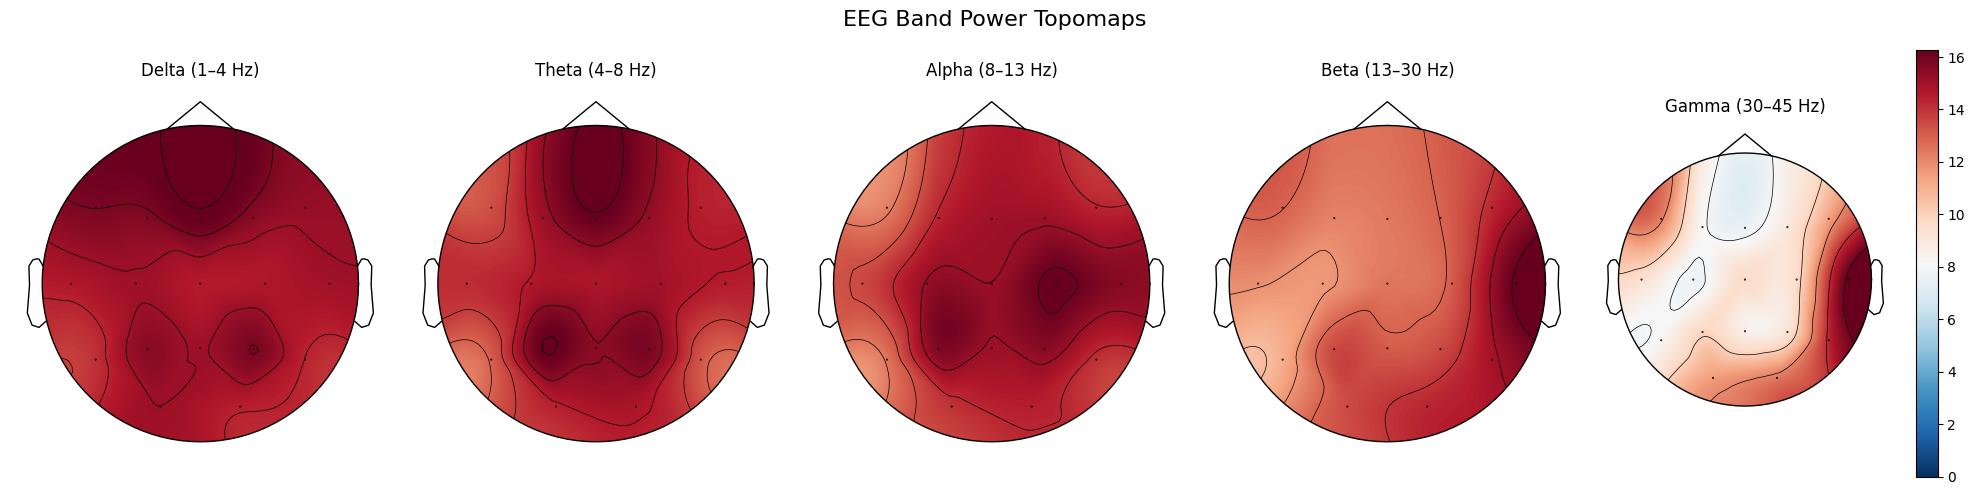

Effective window size : 16.000 (s)


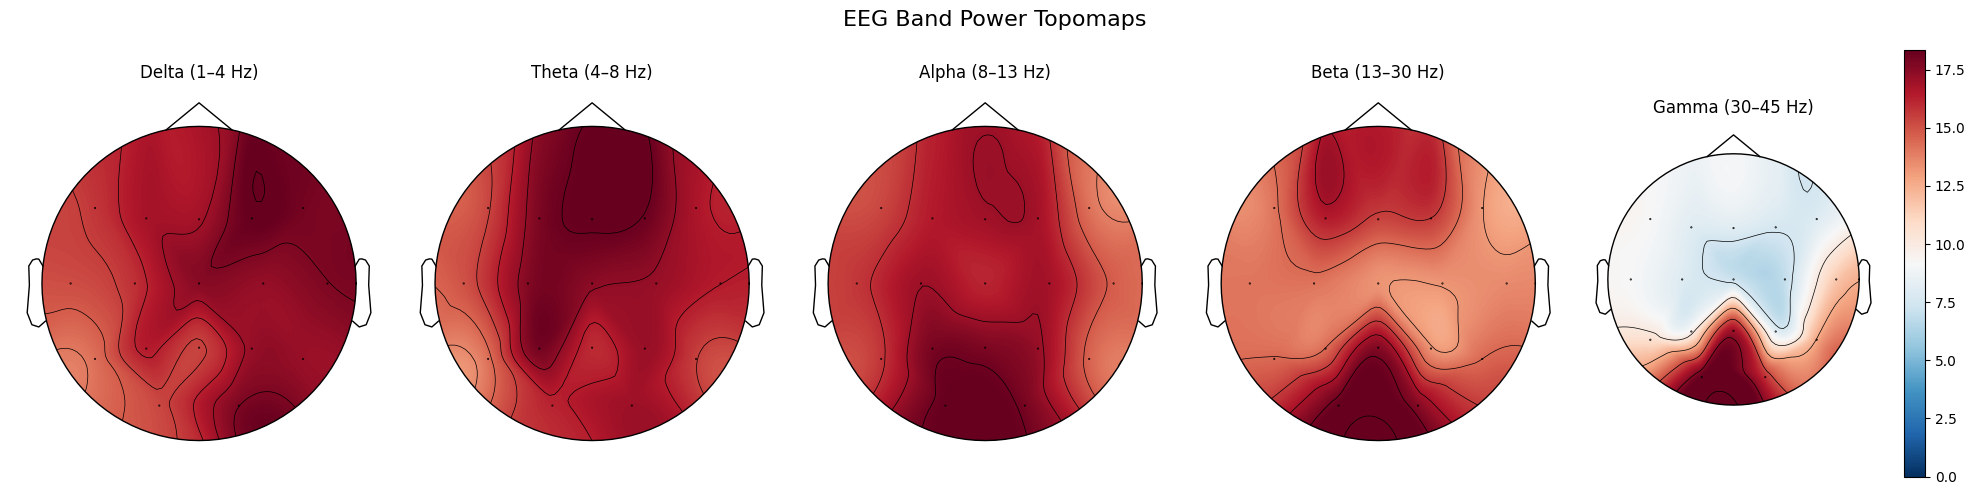

In [ ]:
#plot each band in topomap
def plot_topomaps(raw, bands=None):

  #define band frequencies
  if bands is None:
    bands = {
      'Delta (1–4 Hz)': (1, 4),
      'Theta (4–8 Hz)': (4, 8),
      'Alpha (8–13 Hz)': (8, 13),
      'Beta (13–30 Hz)': (13, 30),
      'Gamma (30–45 Hz)': (30, 45),
    }

    psd = raw.compute_psd(fmin=1, fmax=45)
    psds, freqs = psd.get_data(return_freqs=True)
    psds = 10 * np.log10(psds)

    #create the plots
    fig, axes = plt.subplots(1, len(bands), figsize=(20, 5))
    fig.suptitle("EEG Band Power Topomaps", fontsize=16)

    for ax, (band_name, (fmin, fmax)) in zip(axes, bands.items()):
      #find indicies of frequescies in band
      idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
      band_power = psds[ :, idx_band].mean(axis=1)
      im, cn = mne.viz.plot_topomap(band_power, raw.info, axes=ax, show=False, cmap='RdBu_r', contours=6, sensors=True, sphere=1.25)
      ax.set_title(band_name)

    #Plot topomaps
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

plot_topomaps(raw_adhd)
plot_topomaps(raw_control)

In [ ]:
#split into fixed length epochs
epochs_list = []

for raw, label in labeled_ds:
  epochs = mne.make_fixed_length_epochs(raw, duration=5, preload=True) #try for one second epochs, see if changes anything
  epochs_list.append((epochs, label))

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 640 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 640 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 640 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 640 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 640 original time points ...
0

In [ ]:
def extract_band_power(epoch_data, sfreq=128):
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=['eeg'] * len(channel_names))
    raw = mne.io.RawArray(epoch_data, info)

    #use compute PSD to get power spectral density
    psd = raw.compute_psd(fmin=1, fmax=45, n_fft=256)
    psds, freqs = psd.get_data(return_freqs=True)

    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (13, 30), 'gamma': (30, 45)}
    features = []
    for band_name, (fmin, fmax) in bands.items():
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power = np.mean(psds[:, idx], axis=1)
        features.extend(band_power)
    return features

X = []
y = []
tot = 0

for epochs, label in epochs_list:
  for epoch in epochs.get_data():
    features = extract_band_power(epoch)
    X.append(features)
    y.append(label)



Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)
Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)
Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)
Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)
Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)
Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)
Creating RawArray with float64 data, n_channel

##Visualize

Creating RawArray with float64 data, n_channels=19, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
Effective window size : 2.000 (s)


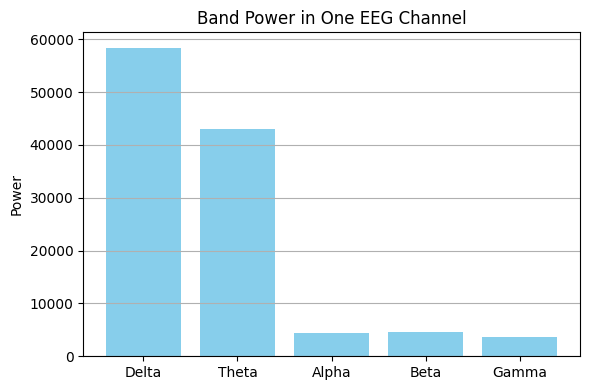

In [ ]:
#band power visualization
example_psd = extract_band_power(epochs_list[0][0].get_data()[0])  # one epoch
band_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
channel0 = np.array(example_psd[:5])  # band power of first channel (5 bands)

plt.figure(figsize=(6, 4))
plt.bar(band_labels, channel0, color='skyblue')
plt.title('Band Power in One EEG Channel')
plt.ylabel('Power')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

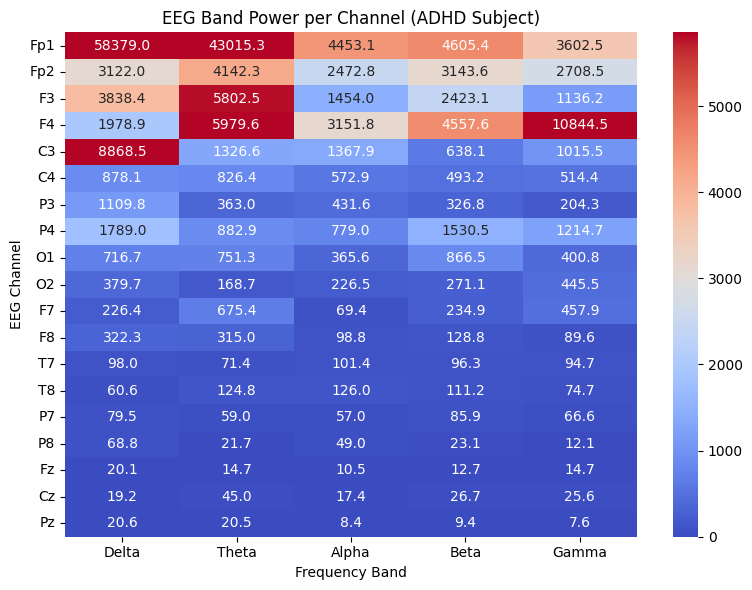

In [ ]:
sample_features = np.array(X[0]).reshape(19, 5)

#use full channel list
channel_names = sample_raw.ch_names

#determine clip range
clip_max = np.percentile(sample_features, 95)

#plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sample_features, annot=True, fmt=".1f", cmap='coolwarm',
            yticklabels=channel_names,
            xticklabels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'],
            vmin=0, vmax=clip_max)  #clip to reduce the skew from high values

plt.title('EEG Band Power per Channel (ADHD Subject)')
plt.xlabel('Frequency Band')
plt.ylabel('EEG Channel')
plt.tight_layout()
plt.show()


<ipython-input-22-855a5ee39caf>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


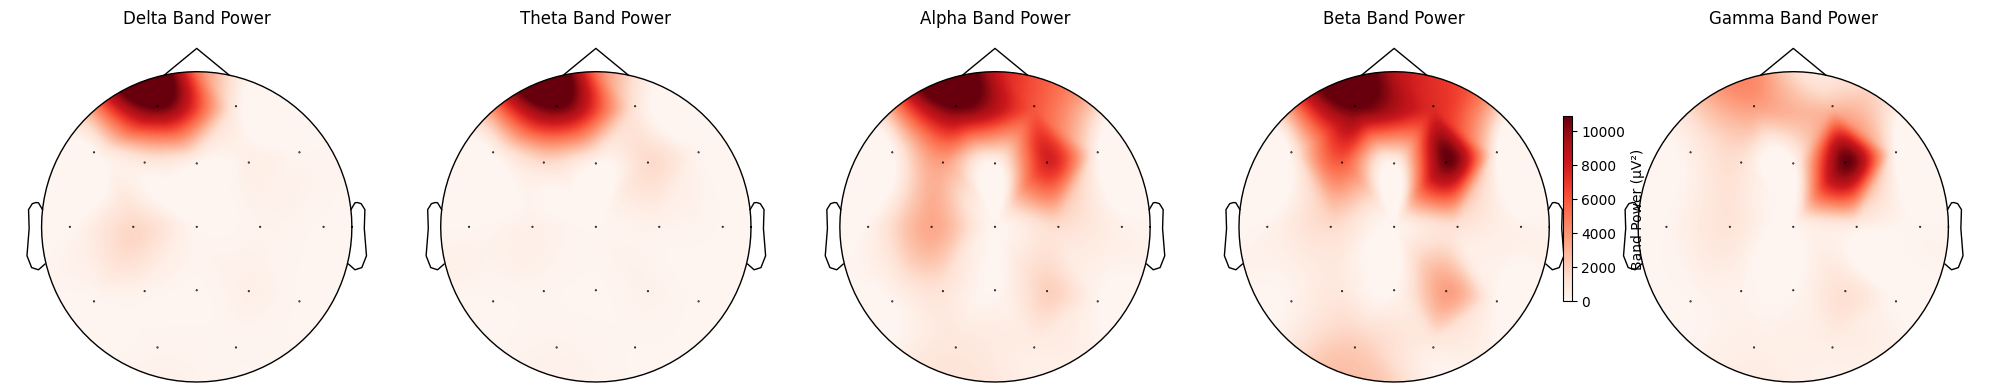

In [ ]:
n_bands = sample_features.shape[1]
band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'][:n_bands]

plot_info = sample_raw.info.copy()
plot_info.set_channel_types({'Fp1': 'eeg', 'Fp2': 'eeg'})

fig, axes = plt.subplots(1, n_bands, figsize=(4 * n_bands, 4))

for i, ax in enumerate(axes):
    band_power = sample_features[:, i]
    im, cn = plot_topomap(
        band_power,
        plot_info,
        axes=ax,
        cmap='Reds',
        show=False,
        contours=0,
        sphere=1.25
    )
    ax.set_title(f"{band_names[i]} Band Power")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='Band Power (μV²)')
plt.tight_layout()
plt.show()


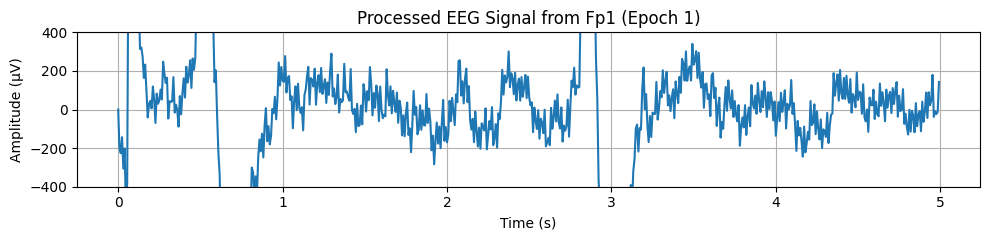

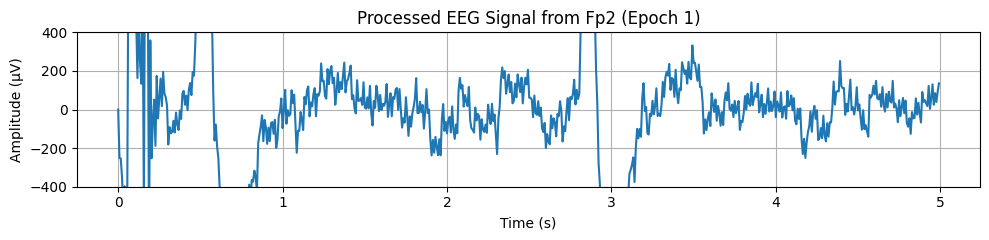

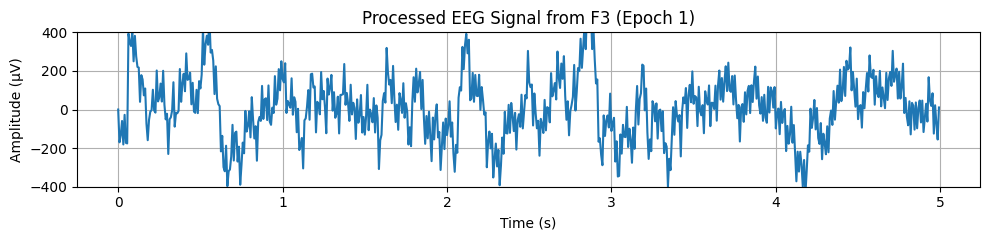

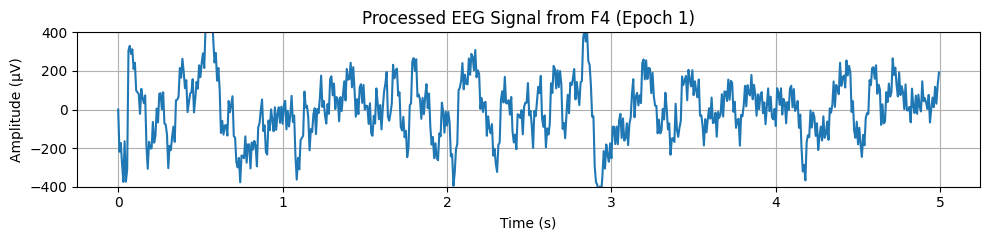

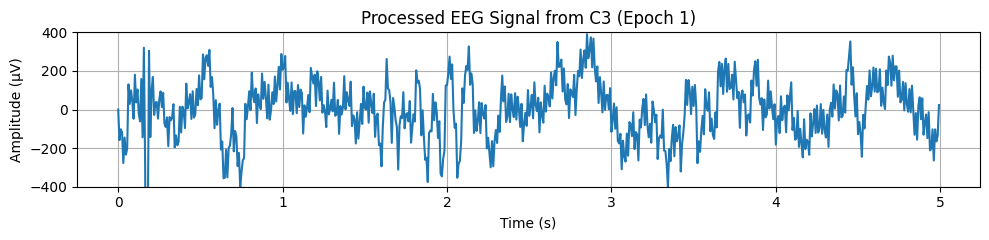

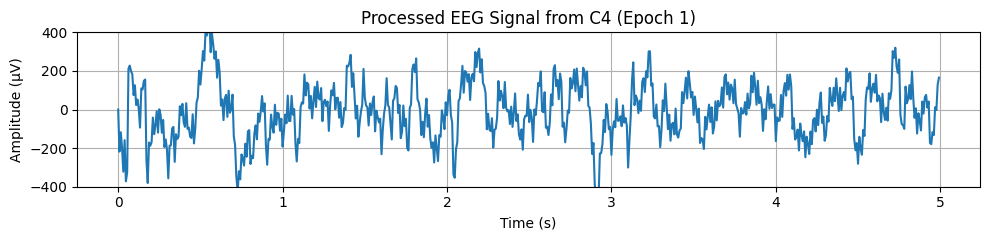

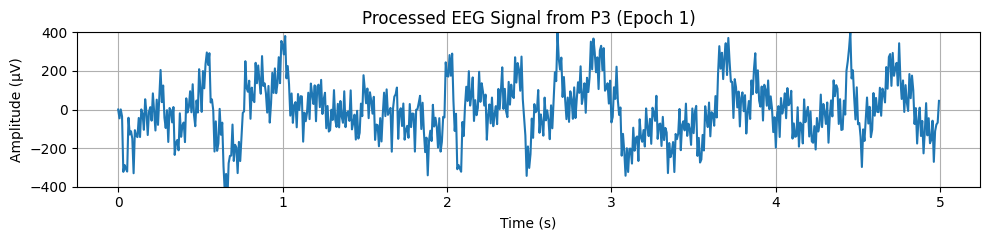

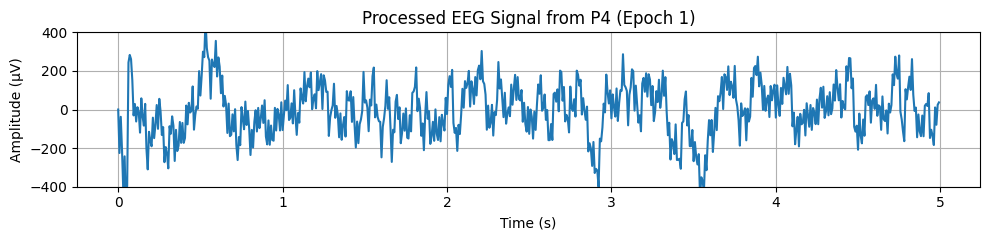

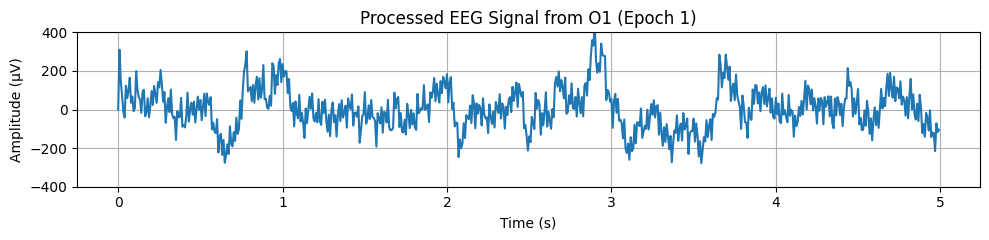

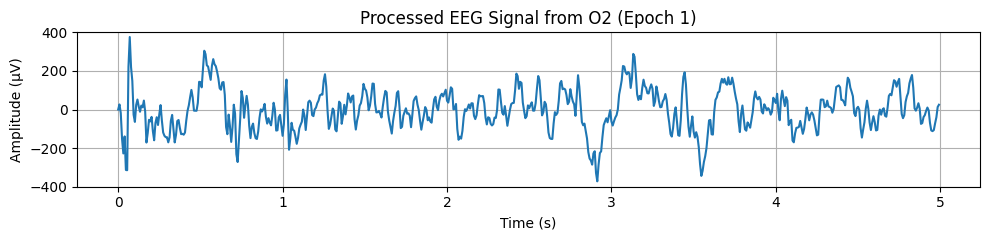

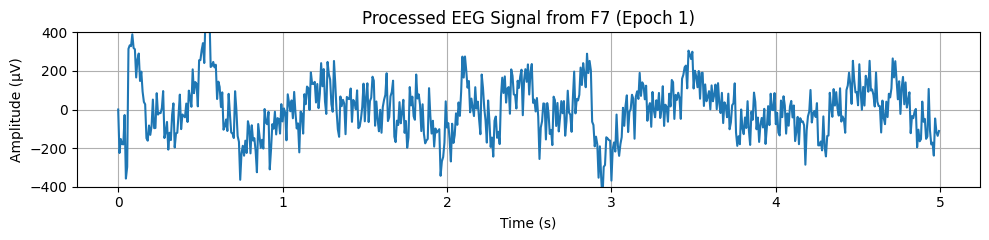

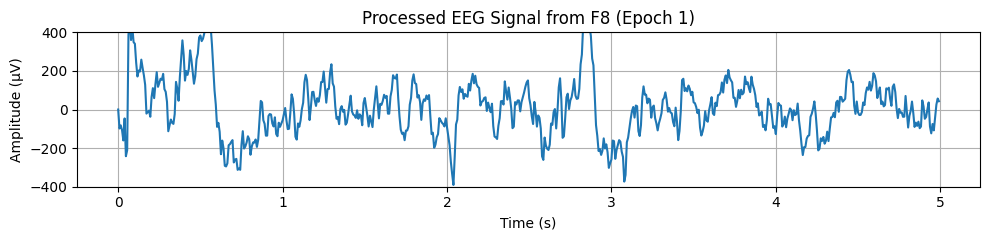

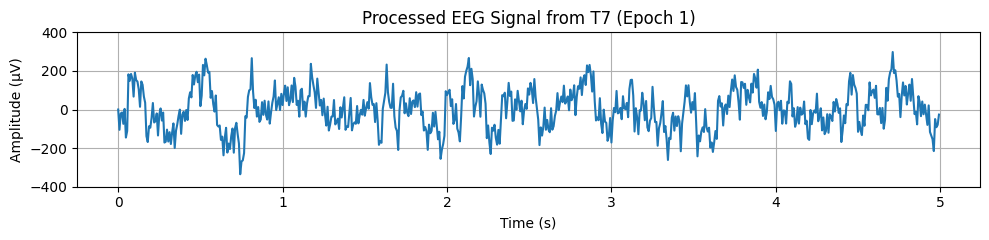

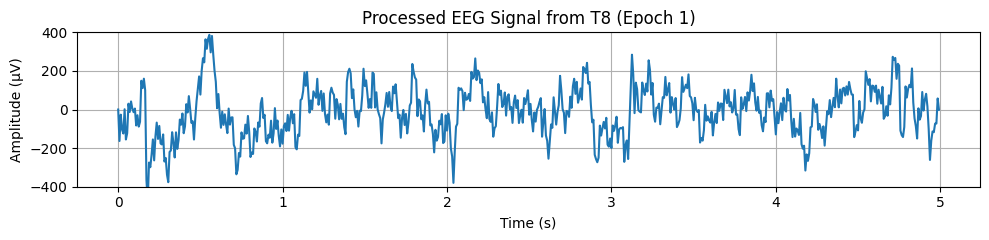

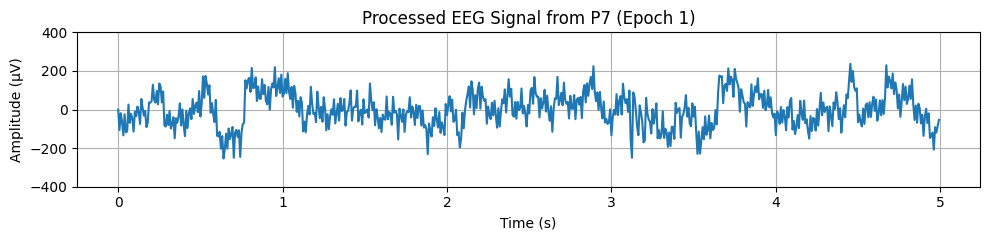

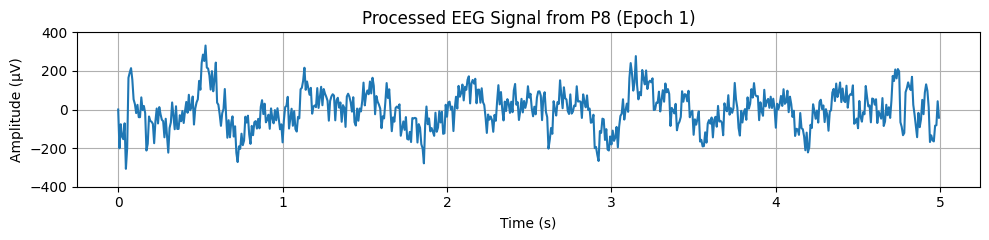

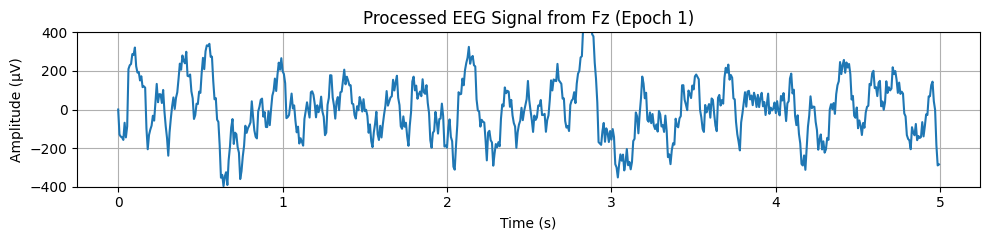

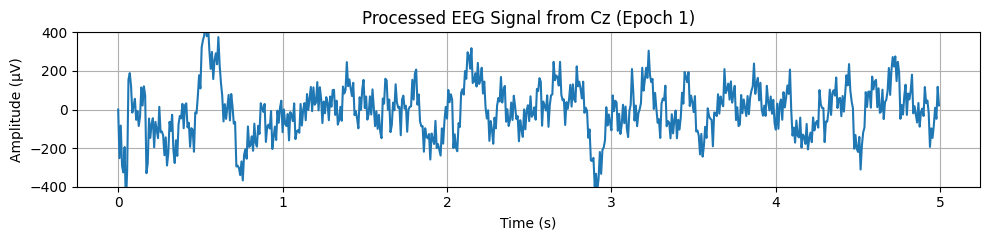

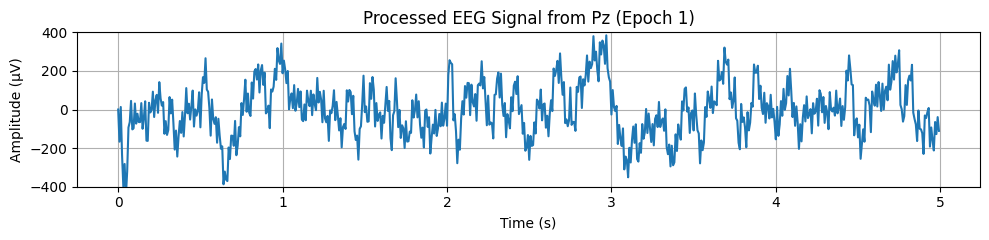

In [ ]:
#select first epoch (ADHD subject)
epoch_data = epochs_list[0][0].get_data()[0]  # shape: (n_channels, n_times)
sfreq = epochs_list[0][0].info['sfreq']
times = np.arange(epoch_data.shape[1]) / sfreq
channel_names = epochs_list[0][0].info['ch_names']

#plot each channel in its own figure
for i, channel in enumerate(channel_names):
    plt.figure(figsize=(10, 2.5))
    plt.plot(times, epoch_data[i])
    plt.title(f'Processed EEG Signal from {channel} (Epoch 1)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.ylim(-400, 400)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

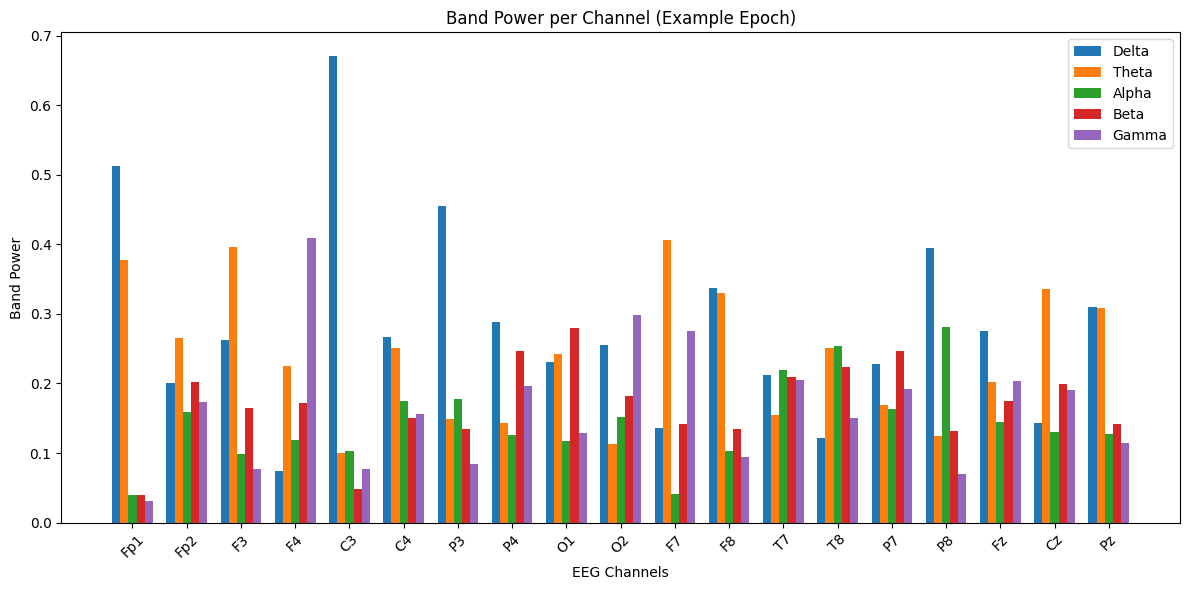

In [ ]:
#create bar chart of band powers
def band_powers_plot(X, y, channel_names):
  bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
  n_channels = 20

  sample_i = 0
  sample_f = X[sample_i]

  n_bands = len(bands)
  n_channels = len(sample_f) // n_bands

  band_power = np.array(sample_f).reshape(n_channels, n_bands)

  band_power_sum = band_power.sum(axis=1, keepdims=True) + 1e-10  #add epsilon to avoid division by zero
  band_power_norm = band_power / band_power_sum

  fig, ax = plt.subplots(figsize=(12, 6))

  x = np.arange(n_channels)
  width = 0.15

  for i, band in enumerate(bands):
    ax.bar(x + i * width, band_power_norm[:, i], width, label=band)

  ax.set_xlabel('EEG Channels')
  ax.set_ylabel('Band Power')
  ax.set_title('Band Power per Channel (Example Epoch)')
  ax.set_xticks(x + width * 2)

  if len(channel_names) == n_channels:
    ax.set_xticklabels(channel_names, rotation=45)
  else:
    ax.set_xticklabels([f'Ch{ch+1}' for ch in range(n_channels)], rotation=45)

  ax.legend()
  plt.tight_layout()
  plt.show()

band_powers_plot(X, y, channel_names)

#Train Models


##Split Data


In [ ]:
X = np.array(X)  #features
y = np.array(y)  #labels

print(X.shape)
print(y.shape)

(720, 95)
(720,)


##Visualize the data now

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Decision Tree Model

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

##Support Vector Model

In [ ]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

#Compare Model Accuracy

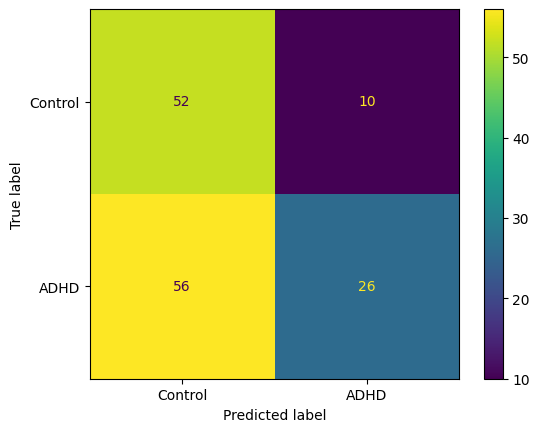

Classification Report For Support Vector Model:
               precision    recall  f1-score   support

           0       0.48      0.84      0.61        62
           1       0.72      0.32      0.44        82

    accuracy                           0.54       144
   macro avg       0.60      0.58      0.53       144
weighted avg       0.62      0.54      0.51       144

Accuracy Score: 0.5416666666666666


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()
print("Classification Report For Support Vector Model:\n", classification_report(y_test, y_pred_svm))
print("Accuracy Score:", accuracy_score(y_test, y_pred_svm))

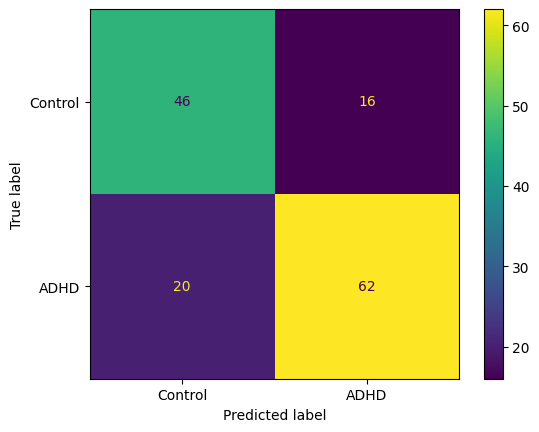

Classification Report For Decision Tree:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72        62
           1       0.79      0.76      0.78        82

    accuracy                           0.75       144
   macro avg       0.75      0.75      0.75       144
weighted avg       0.75      0.75      0.75       144

Accuracy Score: 0.75


In [ ]:
#Confusion Matrix for Decision Tree
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()
print("Classification Report For Decision Tree:\n", classification_report(y_test, y_pred_dt))
print("Accuracy Score:", accuracy_score(y_test, y_pred_dt))

KNN Accuracy: 0.7013888888888888


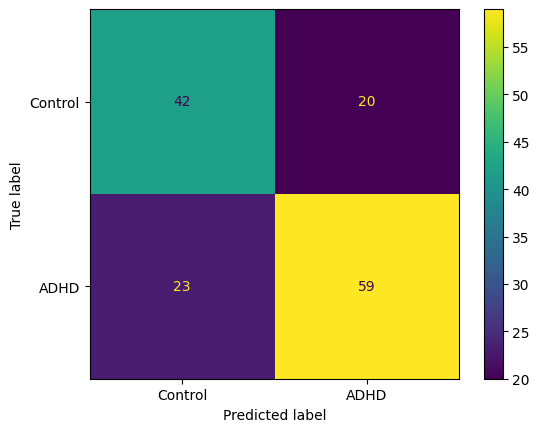

Classification Report For KNN Model:
               precision    recall  f1-score   support

           0       0.65      0.68      0.66        62
           1       0.75      0.72      0.73        82

    accuracy                           0.70       144
   macro avg       0.70      0.70      0.70       144
weighted avg       0.70      0.70      0.70       144



In [ ]:

#initialize knn model
knn_model = KNeighborsClassifier(n_neighbors=5) # You can adjust the number of neighbors

#train model
knn_model.fit(X_train, y_train)

#make predictions
y_pred_knn = knn_model.predict(X_test)

#evaluate
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {knn_accuracy}")

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()
print("Classification Report For KNN Model:\n", classification_report(y_test, y_pred_knn))


##Random Forest

Classification Report For Random Forest:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        62
           1       0.91      0.83      0.87        82

    accuracy                           0.85       144
   macro avg       0.85      0.86      0.85       144
weighted avg       0.86      0.85      0.85       144

Random Forest Accuracy: 0.8541666666666666


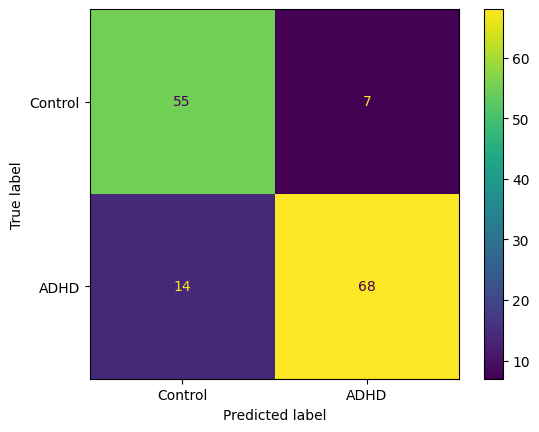

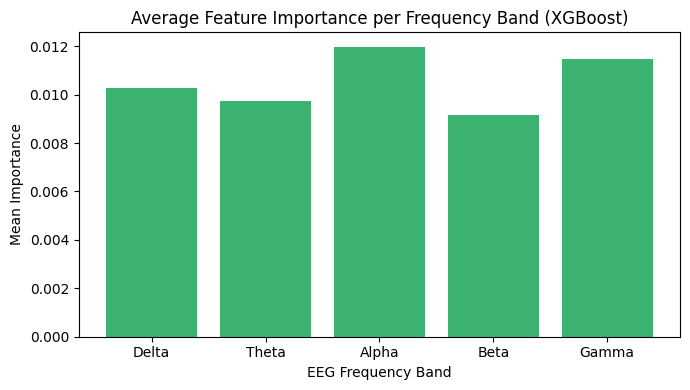

Most important band based on RF: Alpha


In [ ]:
#train rf
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# evaluate
y_pred_rf = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Classification Report For Random Forest:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", rf_accuracy)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()

importances = rf_model.feature_importances_
importances = np.array(importances).reshape(19, 5)

#average importance
band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
band_scores = importances.mean(axis=0)

#plot
plt.figure(figsize=(7, 4))
plt.bar(band_names, band_scores, color='mediumseagreen')
plt.title("Average Feature Importance per Frequency Band (XGBoost)")
plt.ylabel("Mean Importance")
plt.xlabel("EEG Frequency Band")
plt.tight_layout()
plt.show()

#print most important band
most_important_band = band_names[np.argmax(band_scores)]
print("Most important band based on RF:", most_important_band)

##xgbOOST

XGBoost Accuracy: 0.8680555555555556
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        62
           1       0.94      0.82      0.88        82

    accuracy                           0.87       144
   macro avg       0.87      0.88      0.87       144
weighted avg       0.88      0.87      0.87       144



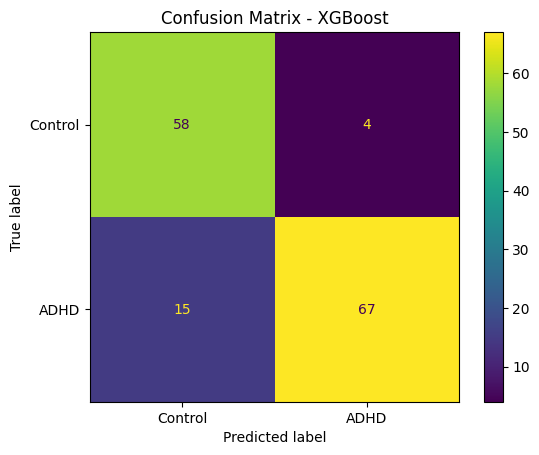

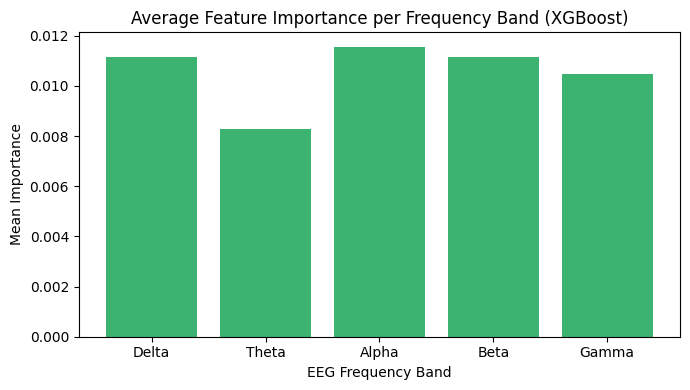

Most important band based on XGBoost: Alpha


In [ ]:
#train model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", xgb_accuracy)
print(classification_report(y_test, y_pred_xgb))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

importances = xgb_model.feature_importances_
importances = np.array(importances).reshape(19, 5)

#average importance
band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
band_scores = importances.mean(axis=0)

#plot
plt.figure(figsize=(7, 4))
plt.bar(band_names, band_scores, color='mediumseagreen')
plt.title("Average Feature Importance per Frequency Band (XGBoost)")
plt.ylabel("Mean Importance")
plt.xlabel("EEG Frequency Band")
plt.tight_layout()
plt.show()

#print most important band
most_important_band = band_names[np.argmax(band_scores)]
print("Most important band based on XGBoost:", most_important_band)


In [ ]:
dt_accuracy = accuracy_score(y_test, y_pred_dt)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
knn_accuracy = accuracy_score(y_test, y_pred_knn)



print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"XGBoost Accuracy: {xgb_accuracy}")

Decision Tree Accuracy: 0.75
SVM Accuracy: 0.5416666666666666
KNN Accuracy: 0.7013888888888888
Random Forest Accuracy: 0.8541666666666666
XGBoost Accuracy: 0.8680555555555556


#Hyperparameter Tuning

##Decision Tree

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best Decision Tree Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Cross-Validated Accuracy: 0.7655022488755623
Test Accuracy: 0.7291666666666666
Classification Report For Tuned DT:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        62
           1       0.78      0.73      0.75        82

    accuracy                           0.73       144
   macro avg       0.73      0.73      0.73       144
weighted avg       0.73      0.73      0.73       144



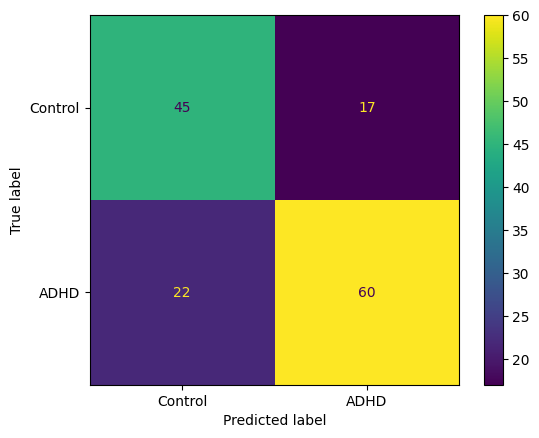

In [ ]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

dt_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_
print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Cross-Validated Accuracy:", dt_grid.best_score_)

y_pred_dt = best_dt.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report For Tuned DT:\n", classification_report(y_test, y_pred_dt))

#cinfusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()


##KNN

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-Validated Accuracy: 0.7655022488755622
Test Accuracy: 0.7847222222222222
Classification Report For Tuned KNN:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        62
           1       0.83      0.78      0.81        82

    accuracy                           0.78       144
   macro avg       0.78      0.79      0.78       144
weighted avg       0.79      0.78      0.79       144



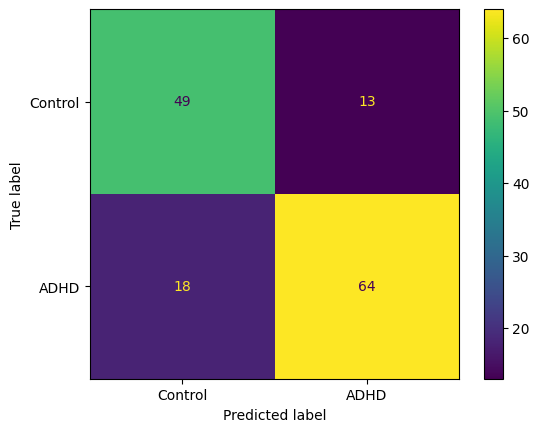

In [ ]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train, y_train)

best_knn = knn_grid.best_estimator_
print("Best KNN Parameters:", knn_grid.best_params_)
print("Best Cross-Validated Accuracy:", knn_grid.best_score_)

y_pred_knn = best_knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report For Tuned KNN:\n", classification_report(y_test, y_pred_knn))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()


##RF

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 150}
Best Cross-Validated Accuracy: 0.9010344827586207
Test Accuracy: 0.8680555555555556
Classification Report For Tuned Random Forest:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85        62
           1       0.92      0.84      0.88        82

    accuracy                           0.87       144
   macro avg       0.87      0.87      0.87       144
weighted avg       0.87      0.87      0.87       144



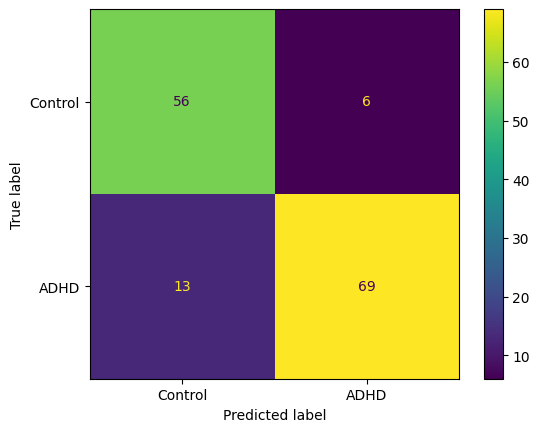

In [ ]:
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_leaf': [1, 2, 4],
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)

#get best model
best_rf = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Cross-Validated Accuracy:", rf_grid.best_score_)

#evaluate
y_pred_rf = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report For Tuned Random Forest:\n", classification_report(y_test, y_pred_rf))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()


##XGBoost

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:41:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validated Accuracy: 0.8906296851574214
Test Accuracy: 0.8680555555555556
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        62
           1       0.91      0.85      0.88        82

    accuracy                           0.87       144
   macro avg       0.86      0.87      0.87       144
weighted avg       0.87      0.87      0.87       144



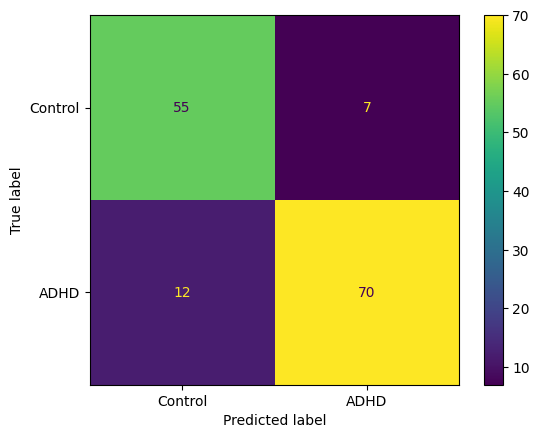

In [ ]:
xgb_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train, y_train)

#results
print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best Cross-Validated Accuracy:", xgb_grid.best_score_)

y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'ADHD'])
disp.plot()
plt.show()


#Ensemble Model

In [ ]:
rf_best = rf_grid.best_estimator_
dt_best = dt_grid.best_estimator_
knn_best = knn_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

##Model 1

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('rf', rf_best),
        ('knn', knn_best)
    ],
    voting='soft'  # use 'hard' if you want majority vote instead of probabilities
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

print("Voting Ensemble Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:50:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Ensemble Accuracy: 0.8958333333333334
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        62
           1       0.94      0.88      0.91        82

    accuracy                           0.90       144
   macro avg       0.89      0.90      0.89       144
weighted avg       0.90      0.90      0.90       144



##Model 2

In [ ]:
stacked_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('rf', rf_best),
        ('knn', knn_best),
        ('dt', dt_best)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacked_clf.fit(X_train, y_train)
y_pred_stack = stacked_clf.predict(X_test)

print("Stacked Ensemble Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

Stacked Ensemble Accuracy: 0.9027777777777778
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        62
           1       0.95      0.88      0.91        82

    accuracy                           0.90       144
   macro avg       0.90      0.91      0.90       144
weighted avg       0.91      0.90      0.90       144

